In [1]:
from seiches_time_series import *

time_series_no_seiche = generate_surge(type=SeicheType.NoSeiches)
time_series_nse = generate_surge(type=SeicheType.Nse)
time_series_scn_1 = generate_surge(type=SeicheType.BasePeriod)
time_series_scn_2 = generate_surge(type=SeicheType.TwoPeaks)
time_series_scn_3 = generate_surge(type=SeicheType.LeftPeak)
time_series_scn_4 = generate_surge(type=SeicheType.RightPeak)
time_series_scn_5 = generate_surge(type=SeicheType.ThreePeriods)

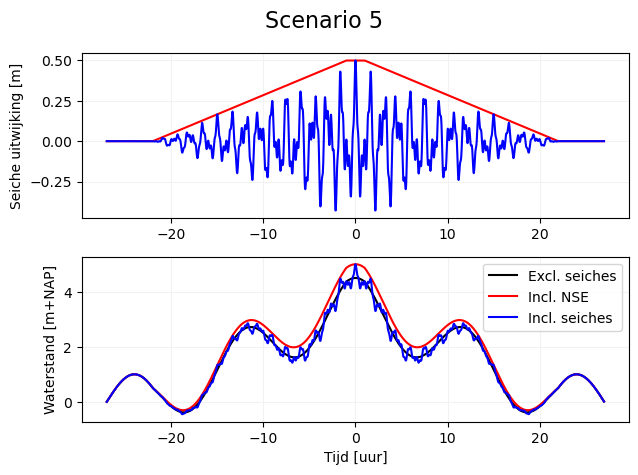

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=1, nrows=2)
fig.suptitle("Scenario 5", fontsize=16)

axs[0].plot(time_series_nse.times,time_series_nse.seiches_signal,'r', label='Incl. NSE')
axs[0].plot(time_series_scn_5.times,time_series_scn_5.seiches_signal,'b', label='Incl. seiches')
axs[0].grid(True,color=(0.95,0.95,0.95))
axs[0].set(ylabel='Seiche uitwijking [m]')

axs[1].plot(time_series_no_seiche.times,time_series_no_seiche.water_levels,'k', label='Excl. seiches')
axs[1].plot(time_series_nse.times,time_series_nse.water_levels,'r', label='Incl. NSE')
axs[1].plot(time_series_scn_5.times,time_series_scn_5.water_levels,'b', label='Incl. seiches')
axs[1].grid(True,color=(0.95,0.95,0.95))
axs[1].set(ylabel='Waterstand [m+NAP]', xlabel='Tijd [uur]')
axs[1].legend()

fig.tight_layout()

In [3]:
series = read_signal_from_file(
        "N:/Projects/11211500/11211573/B. Measurements and calculations/001 HB - seiches/Tijdreeksen/Gemeten/seiche_peak_8_timeseries.txt"
    )

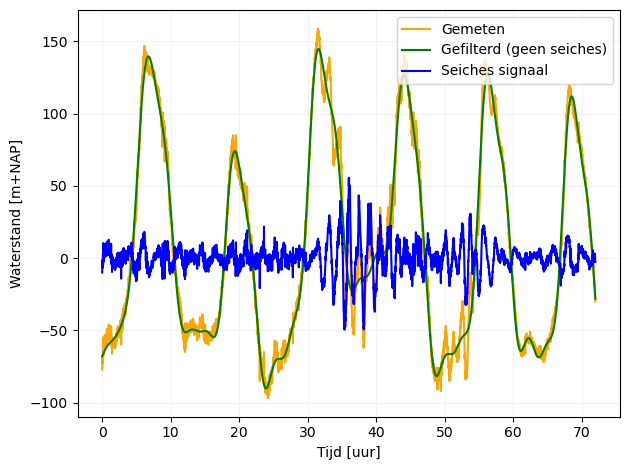

In [4]:
fig, axs = plt.subplots(ncols=1, nrows=1)

axs.plot([t / 3600 for t in series.times],series.water_levels_measured,'orange', label='Gemeten')
axs.plot([t / 3600 for t in series.times],series.water_levels_filtered,'g', label='Gefilterd (geen seiches)')
axs.plot([t / 3600 for t in series.times],series.seiches_signal,'b', label='Seiches signaal')

axs.grid(True,color=(0.95,0.95,0.95))
axs.set(ylabel='Waterstand [m+NAP]', xlabel='Tijd [uur]')
axs.legend()

fig.tight_layout()

In [5]:
import sys
from pathlib import Path

pydrever_parent_path = Path("C:/src/pydrever")
if str(pydrever_parent_path) not in sys.path:
    sys.path.append(str(pydrever_parent_path))
    print("Added python parent directory: " + str(pydrever_parent_path))

import pydrever
print(pydrever.__file__)

Added python parent directory: C:\src\pydrever
C:\src\pydrever\pydrever\__init__.py


In [6]:
from pydrever.io import prflreader

schematization = prflreader.read(r"n:\Projects\11211500\11211573\B. Measurements and calculations\001 HB - seiches\Profielen\LocatieA_AHN.prfl")
print(min(schematization.x_positions))
print(max(schematization.x_positions))


0.0
15.8


In [7]:
import numpy
import matplotlib.pyplot as plt


from pydrever.visualization import (
    plot_damage_levels,
    plot_hydrodynamic_conditions,
    plot_development_per_location,
)

import pydrever.data as data
from pydrever.calculation import Dikernel


In [8]:

water_levels = time_series_scn_5.water_levels[:-1]
wave_heights = np.full(len(water_levels), 2.2)
wave_periods = np.full(len(water_levels), 7.5)
wave_directions = np.full(len(water_levels), schematization.dike_orientation)

hydrodynamic_conditions = data.HydrodynamicConditions(
    time_steps=time_series_scn_5.times, 
    water_levels=water_levels, 
    wave_heights=wave_heights, 
    wave_periods=wave_periods, 
    wave_directions=wave_directions
)

In [9]:
dikernel_input = data.DikernelInput(dike_schematization=schematization, hydrodynamic_input=hydrodynamic_conditions)

In [10]:
def create_output_location(x_position: float, grass_layer_type: data.TopLayerType):
    return data.OutputLocationSpecification(
        x_position=x_position, 
        top_layer_specification=data.GrassWaveImpactLayerSpecification(grass_layer_type))

output_locations = np.arange(1.0, 15.0, 1.0)
for x_location in output_locations:
    dikernel_input.add_output_location(
        x_location=x_location, 
        top_layer_specification=data.GrassWaveImpactLayerSpecification(
            top_layer_type=data.TopLayerType.GrassClosedSod)
            )

In [11]:
kernel = pydrever.calculation.Dikernel(dikernel_input)
runresult = kernel.run()

Number of output locations: 14
   Failed, X: 1.0, Damage level = 3.7999999999944585
   Failed, X: 2.0, Damage level = 3.822222222216647
   Failed, X: 3.0, Damage level = 4.422222222215782
   Failed, X: 4.0, Damage level = 4.466666666660161
   Failed, X: 5.0, Damage level = 2.7666666666626174
   Not failed, X: 6.0, Damage level = 0.8999999999986835
   Failed, X: 7.0, Damage level = 1.2555555555537141
   Failed, X: 8.0, Damage level = 1.0166666666651794
   Not failed, X: 9.0, Damage level = 0.20555555555525465
   Not failed, X: 10.0, Damage level = 0.005555555555547419
   Not failed, X: 11.0, Damage level = 0.0
   Not failed, X: 12.0, Damage level = 0.0
   Not failed, X: 13.0, Damage level = 0.0
   Not failed, X: 14.0, Damage level = 0.0


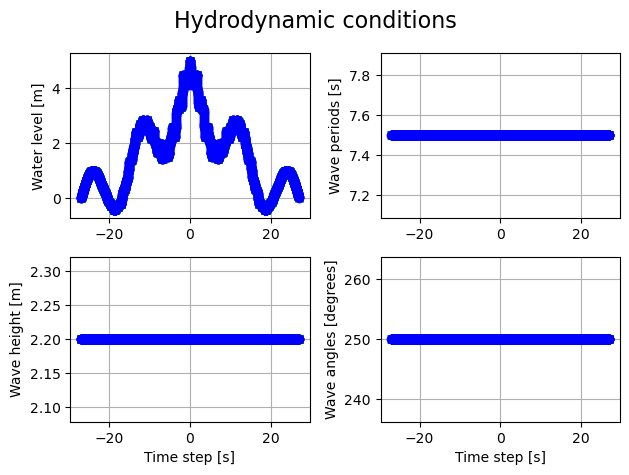

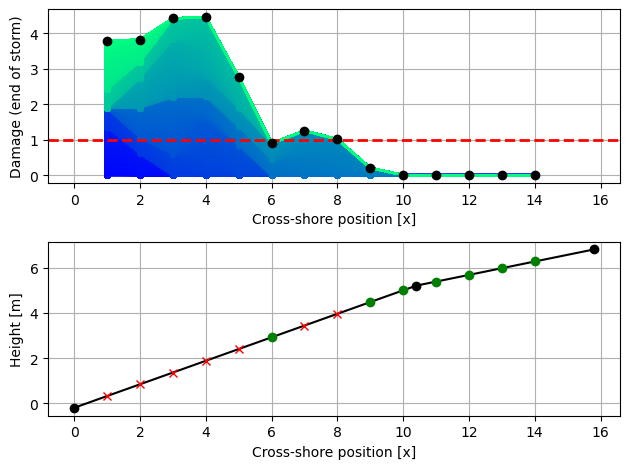

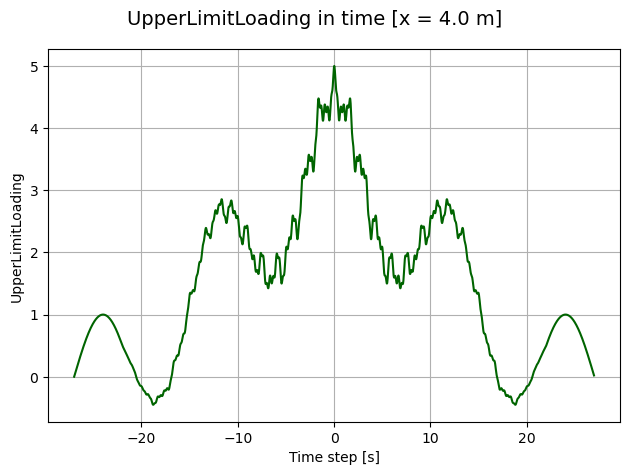

In [12]:
output = kernel.output

print("Number of output locations: " + str(len(output)))
for location in output:
    print(
        "   "
        + ("Failed" if location.failed else "Not failed")
        + ", X: "
        + str(location.x_position)
        + ", Damage level = "
        + str(location.damage_development[-1])
    )

fig = pydrever.visualization.plot_hydrodynamic_conditions(dikernel_input)

fig2 = pydrever.visualization.plot_damage_levels(output, dikernel_input)

fig3 = pydrever.visualization.plot_development_per_location(
    output[3], data.TimeDependentOutputQuantity.UpperLimitLoading, dikernel_input
)

plt.show()
